In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
use_cuda = True

device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
lr = 7.196856730011514e-05

In [5]:
batch_size = 64
epochs = 10

# Data

* `get_mnist`
* `build_data_loaders`

In [6]:
from data_utils import get_mnist, build_data_loaders

In [7]:
train_dataset, test_dataset = get_mnist(normalize=True)

# Build data loaders
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

In [8]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


# Model

In [9]:
from net import Net

In [10]:
net = Net().to(device)

In [11]:
device

device(type='cuda')

# Custom optimizers

In [12]:
from optimizer import NesterovOptimizer

In [13]:
optim = NesterovOptimizer(net.parameters(), lr=lr)

# Training

In [14]:
from training import training, accuracy, testing
from torch.nn import CrossEntropyLoss

In [15]:
loss_train, acc_train = training(
    model=net,
    dataset=train_loader,
    optim=optim,
    loss_fun=CrossEntropyLoss(),
    metric_fun=accuracy,
    epochs=epochs,
    device=device,
    batch_log_interval=0
)

Launching training on cuda
epoch 0	avg epoch loss = 1.235	avg epoch acc = 0.6698
epoch 1	avg epoch loss = 0.1744	avg epoch acc = 0.9481
epoch 2	avg epoch loss = 0.07812	avg epoch acc = 0.9755
epoch 3	avg epoch loss = 0.0568	avg epoch acc = 0.9825
epoch 4	avg epoch loss = 0.04209	avg epoch acc = 0.987
epoch 5	avg epoch loss = 0.02996	avg epoch acc = 0.9904
epoch 6	avg epoch loss = 0.02397	avg epoch acc = 0.9923
epoch 7	avg epoch loss = 0.02145	avg epoch acc = 0.9929
epoch 8	avg epoch loss = 0.01667	avg epoch acc = 0.9944
epoch 9	avg epoch loss = 0.01786	avg epoch acc = 0.9943
training took 18.51 s


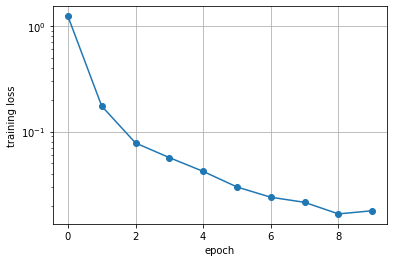

In [16]:
plt.semilogy(np.mean(loss_train, axis=1), '-o')
plt.xlabel('epoch'); plt.ylabel('training loss')
plt.grid();

In [17]:
loss_test, acc_test = testing(
    model=net,
    dataset=test_loader,
    loss_fun=CrossEntropyLoss(),
    metric_fun=accuracy,
    device=device
)

Avg test loss = 0.0411	Avg test acc = 0.988


# Adversarial training

## Attack naive model

In [18]:
from adversary import attack, protect

In [21]:
noise = np.arange(0, 0.5, 0.05)

accuracy_naive= []
losses_naive= []

for ns in noise:
    loss_attack, acc_attack  = attack(
        model=net, 
        loss_fun=CrossEntropyLoss(), 
        test_loader=test_loader, 
        epsilon=ns, 
        device=device
    )
    accuracy_naive.append(acc_attack)
    losses_naive.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.931
Epsilon: 0.05	Test Accuracy = 0.918
Epsilon: 0.10	Test Accuracy = 0.902
Epsilon: 0.15	Test Accuracy = 0.882
Epsilon: 0.20	Test Accuracy = 0.856
Epsilon: 0.25	Test Accuracy = 0.824
Epsilon: 0.30	Test Accuracy = 0.789
Epsilon: 0.35	Test Accuracy = 0.743
Epsilon: 0.40	Test Accuracy = 0.686
Epsilon: 0.45	Test Accuracy = 0.615


## Train robust model

In [22]:
robust_net = Net().to(device)

optim_robust = NesterovOptimizer(robust_net.parameters(), lr=lr)

robust_net = protect(model=robust_net, 
                     optim=optim_robust, 
                     loss_fun=CrossEntropyLoss(), 
                     train_loader=train_loader, 
                     test_loader=test_loader, 
                     device=device, 
                     epochs=epochs)

Epoch 0.00 | Test accuracy: 0.81379
Epoch 1.00 | Test accuracy: 0.93601
Epoch 2.00 | Test accuracy: 0.96029
Epoch 3.00 | Test accuracy: 0.97164
Epoch 4.00 | Test accuracy: 0.96795
Epoch 5.00 | Test accuracy: 0.97572
Epoch 6.00 | Test accuracy: 0.97412
Epoch 7.00 | Test accuracy: 0.96895
Epoch 8.00 | Test accuracy: 0.97442
Epoch 9.00 | Test accuracy: 0.98298
training took 30.89 s


## Attack robust model

In [23]:
noise = np.arange(0, 0.5, 0.05)

accuracy_robust= []
losses_robust= []

for ns in noise:
    loss_attack, acc_attack = attack(
        model=robust_net, 
        loss_fun=CrossEntropyLoss(), 
        test_loader=test_loader, 
        epsilon=ns, 
        device=device
    )
    accuracy_robust.append(acc_attack)
    losses_robust.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.988
Epsilon: 0.05	Test Accuracy = 0.986
Epsilon: 0.10	Test Accuracy = 0.984
Epsilon: 0.15	Test Accuracy = 0.982
Epsilon: 0.20	Test Accuracy = 0.979
Epsilon: 0.25	Test Accuracy = 0.975
Epsilon: 0.30	Test Accuracy = 0.968
Epsilon: 0.35	Test Accuracy = 0.959
Epsilon: 0.40	Test Accuracy = 0.949
Epsilon: 0.45	Test Accuracy = 0.930
